In [89]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything
from pathlib import Path
from skimage.io import imread

import torch
torch.set_float32_matmul_precision("high")

seed_everything(12345)
scvi.settings.seed = 12345

Seed set to 12345
Seed set to 12345


# Preparing data

In [90]:
# # LAPTOP
# segmentation_path = Path("/Users/janzules/Roselab/Spatial/CAR_T/data/cell_segmentation/")

# COMPUTER
segmentation_path = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/cell_segmentation/")
adata_file     = segmentation_path / "concatenated" / "combined_adata.h5ad"
geneList = segmentation_path / "Gene_lists"
fig_out = Path("/Users/janzules/Roselab/Spatial/CAR_T/figures/clustering_results/")
ST_sample = sc.read_h5ad(adata_file)

# ST_sample = ST_sample_org[ST_sample_org.obs['mouse'].isin([sample])].copy()
# del ST_sample_org

## Adding images

In [91]:
# C:/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1

# "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/"

In [92]:
# # LAPTOP
# HNE_TIF_PATHS = {
#     "F07839": Path("/Users/janzules/Roselab/Spatial/dietary_project/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA4_Slide_1.tif"),
#     "F07840": Path("/Users/janzules/Roselab/Spatial/dietary_project/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA5_Slide_1.tif")
# }

# COMPUTER
HNE_TIF_PATHS = {
    "F07839": Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA4_Slide_1.tif"),
    "F07840": Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/images_for_alignments/121724-121924_RL_mRT_TMA4_1_TMA5_1/hne/121724_RL_mRT_TMA5_Slide_1.tif")
}



In [93]:
ST_sample.obsm["spatial"] = ST_sample.obs[["cx", "cy"]].to_numpy()

In [94]:
# 1) Make sure your AnnData knows which “library” (TMA) each spot comes from.
#    We’ll use your existing 'TMA' column as the library_key:
ST_sample.obs['library_id'] = ST_sample.obs['TMA']

# 2) Build the minimal `adata.uns['spatial']` structure Squidpy expects:
#    For each TMA, point to your H&E image (as a numpy array) and set a scale factor.
ST_sample.uns['spatial'] = {}
for lib_id, tif_path in HNE_TIF_PATHS.items():
    img = imread(tif_path)
    ST_sample.uns['spatial'][lib_id] = {
        "images": {"hires": img},
        "scalefactors": {
            "tissue_hires_scalef": 1.0,
            "spot_diameter_fullres": 100.0,   # <- add this
            "tissue_lowres_scalef": 1.0,      # <- add this (not always needed)
        }
    }

In [95]:
sc.pp.filter_genes(ST_sample, min_counts=3)
sc.pp.filter_cells(ST_sample, min_counts=50)

In [96]:
ST_sample.layers['counts'] = ST_sample.X.copy()

In [97]:
sc.pp.normalize_total(ST_sample, target_sum=1e6)
sc.pp.log1p(ST_sample)

# Dimensionality Reduction

In [98]:
scvi.model.SCVI.setup_anndata(
    ST_sample,
    layer="counts",
    batch_key="mouse"
    # batch_key="library_id" # This contains mouse info
)

model = scvi.model.SCVI(ST_sample)

In [99]:
# # LAPTOP
# model.train(early_stopping=True, enable_progress_bar=True, accelerator="mps")

# COMPUTER
model.train(early_stopping=True, enable_progress_bar=True, accelerator="cuda")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 47/47: 100%|██████| 47/47 [13:54<00:00, 17.21s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]

`Trainer.fit` stopped: `max_epochs=47` reached.


Epoch 47/47: 100%|██████| 47/47 [13:54<00:00, 17.76s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=1.05e+3]


In [100]:
ST_sample.obsm['X_scVI'] = model.get_latent_representation(ST_sample).astype(np.float32)

In [101]:
# sq.gr.spatial_neighbors(ST_sample, library_key='mouse', coord_type='generic', delaunay=True)
sq.gr.spatial_neighbors(ST_sample, library_key='mouse', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

# CellCharter's spatial clustering

In [102]:
# grabbing coords for CyPSCA_1_2

# Adjust this column name if needed
subset = ST_sample[ST_sample.obs['mouse'] == 'CyPSCA_1_2']

# Extract (cx, cy) coordinates
coords = subset.obsm['spatial']

# Compute bounding box
xmin = np.min(coords[:, 0])
xmax = np.max(coords[:, 0])
ymin = np.min(coords[:, 1])
ymax = np.max(coords[:, 1])

print(f"xmin: {xmin}, xmax: {xmax}")
print(f"ymin: {ymin}, ymax: {ymax}")


xmin: 3116.4631871012366, xmax: 8908.762357234882
ymin: 3833.2490728455214, ymax: 6528.459009738141


In [103]:
# 1. Subset AnnData for the target mouse/condition
subset = ST_sample[ST_sample.obs['mouse'] == 'CyPSCA_1_2']

# 2. Extract spatial coordinates
coords = subset.obsm['spatial']
xmin, xmax = coords[:, 0].min(), coords[:, 0].max()
ymin, ymax = coords[:, 1].min(), coords[:, 1].max()

# Optional: Add margin (e.g., 100 pixels on each side)
margin = 100
crop_coord = (
    int(xmin - margin),
    int(ymin - margin),
    int(xmax + margin),
    int(ymax + margin)
)

print("Crop coordinates:", crop_coord)


Crop coordinates: (3016, 3733, 9008, 6628)


In [104]:
# Get the unique TMA(s) that contain this mouse
ST_sample.obs.loc[ST_sample.obs['mouse'] == 'CyPSCA_1_2', 'TMA'].unique()

['F07840']
Categories (2, object): ['F07839', 'F07840']

/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


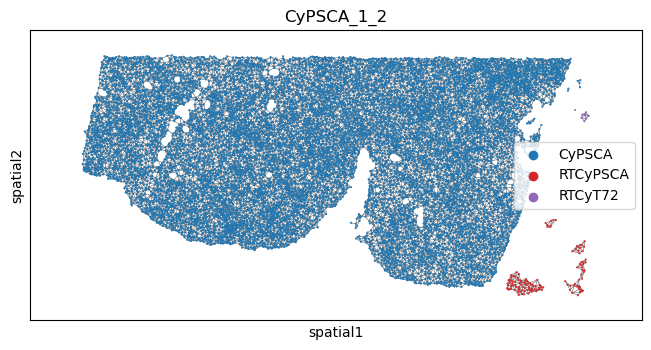

In [105]:
sq.pl.spatial_scatter(
    ST_sample,
    shape=None,
    spatial_key='spatial',
    library_key='library_id',
    library_id=['F07840'],         # or whichever TMA sample contains CyPSCA_1_2
    crop_coord=crop_coord,
    img=True,
    img_alpha=1,
    color='condition',
    connectivity_key='spatial_connectivities',
    size=0.01,
    edges_width=0.3,
    legend_loc='right',
    title=['CyPSCA_1_2']
)


In [106]:
cc.gr.remove_long_links(ST_sample)

/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


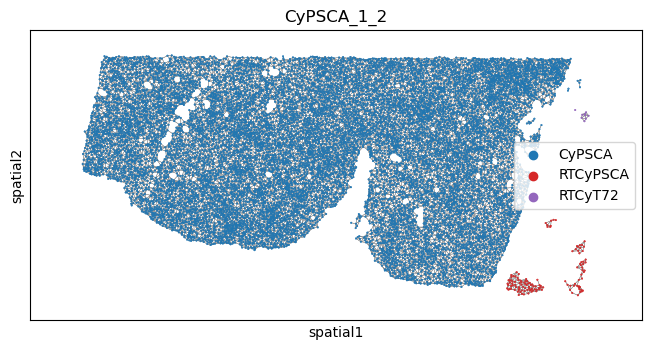

In [107]:
sq.pl.spatial_scatter(
    ST_sample,
    shape=None,
    spatial_key='spatial',
    library_key='library_id',
    library_id=['F07840'],         # or whichever TMA sample contains CyPSCA_1_2
    crop_coord=crop_coord,
    img=True,
    img_alpha=1,
    color='condition',
    connectivity_key='spatial_connectivities',
    size=0.01,
    edges_width=0.3,
    legend_loc='right',
    title=['CyPSCA_1_2']
)


In [108]:
# output = segmentation_path / "scvi_all.h5ad"

In [109]:
# ST_sample.write(output)

# Clustering

In [110]:
# ST_sample = sc.read_h5ad("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/data/cell_segmentation/concatenated/scvi_all.h5ad")

In [111]:
# sq.gr.spatial_neighbors(ST_sample, library_key='mouse', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

In [112]:
cc.gr.aggregate_neighbors(ST_sample, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='mouse')

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.87it/s]


In [113]:
autok = cc.tl.ClusterAutoK(
    n_clusters=(2,20), # ORiginally 2,10
    max_runs=10,
    convergence_tol=0.001
)

In [114]:
autok.fit(ST_sample, use_rep='X_cellcharter')

Iteration 1/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:04<01:26,  4.35s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:06<00:57,  3.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

Iteration 2/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:03<01:19,  3.99s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:06<00:55,  2.92s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

Iteration 3/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:02<00:41,  2.10s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:04<00:43,  2.27s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

Iteration 4/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:02<00:40,  2.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:04<00:38,  2.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

Iteration 5/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:03<01:17,  3.86s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:06<00:54,  2.85s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

Iteration 6/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:01<00:38,  1.93s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:05<00:58,  3.09s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

Iteration 7/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:01<00:39,  1.99s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:04<00:38,  2.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

Iteration 8/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:02<00:41,  2.06s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:06<01:02,  3.27s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

Iteration 9/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:01<00:39,  1.96s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:04<00:39,  2.06s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

Iteration 10/10


  0%|                                                                                        | 0/21 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|███▊                                                                            | 1/21 [00:01<00:38,  1.95s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|███████▌                                                                        | 2/21 [00:03<00:37,  1.98s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_V

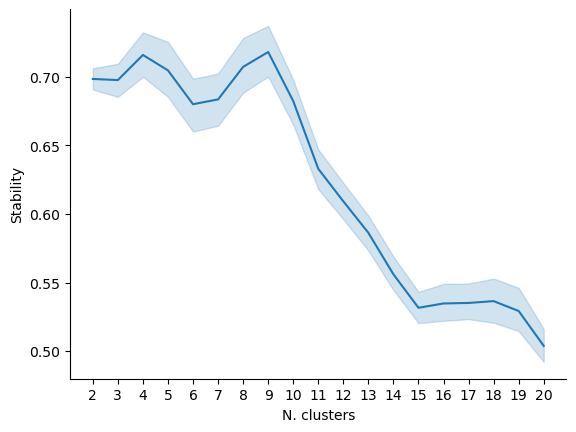

In [115]:
cc.pl.autok_stability(autok)

In [136]:
# ST_sample.obs['cluster_cellcharter'] = autok.predict(ST_sample, use_rep='X_cellcharter')
ST_sample.obs['cluster_cellcharter'] = autok.predict(ST_sample, use_rep='X_cellcharter', k=9) # Forcing 8 clusters

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [137]:
ST_sample.obs.columns

Index(['id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'mouse', 'sample_id', 'condition', 'cx',
       'cy', 'TMA', 'library_id', 'n_counts', '_scvi_batch', '_scvi_labels',
       'cluster_cellcharter'],
      dtype='object')

In [138]:
ST_sample.obs['mouse'].unique()

['RTCyT72_2_1', 'RTCyPSCA_1_4', 'CyPSCA_1_1', 'NoTx_2_2', 'CyPSCA_1_2', 'RTCyT72_2_4', 'RTCyPSCA_2_4', 'CyT72_1_4']
Categories (8, object): ['CyPSCA_1_1', 'CyPSCA_1_2', 'CyT72_1_4', 'NoTx_2_2', 'RTCyPSCA_1_4', 'RTCyPSCA_2_4', 'RTCyT72_2_1', 'RTCyT72_2_4']

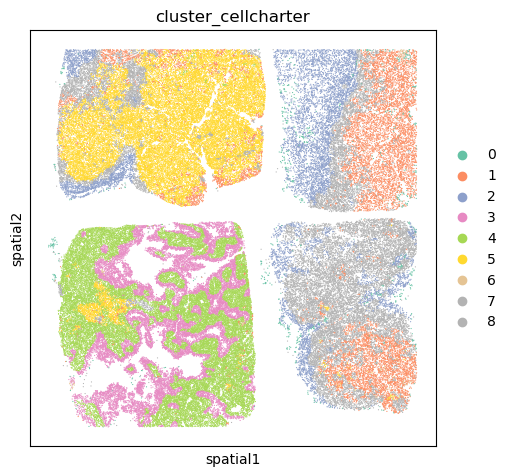

In [147]:
sq.pl.spatial_scatter(
    ST_sample, 
    color=['cluster_cellcharter'], 
    library_key='library_id',  
    size=0.3, 
    img=None,
    spatial_key='spatial',
    palette='Set2',
    figsize=(5,5),
    ncols=1,
    library_id=['F07839']
)

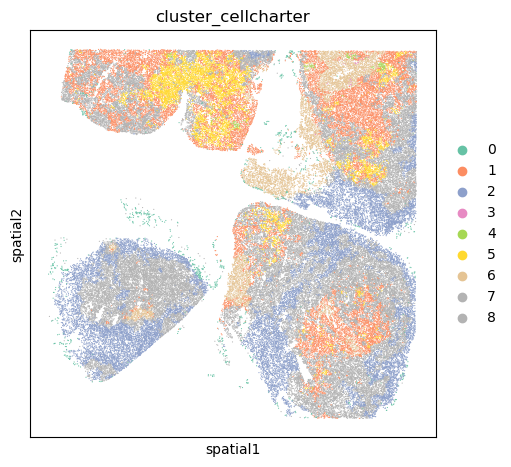

In [144]:
sq.pl.spatial_scatter(
    ST_sample, 
    color=['cluster_cellcharter'], 
    library_key='library_id',  
    size=0.3, 
    img=None,
    spatial_key='spatial',
    palette='Set2',
    figsize=(5,5),
    ncols=1,
    library_id=['F07840']
)

In [ ]:
sq.pl.spatial_scatter(
    ST_sample, 
    color=['cluster_cellcharter'], 
    library_key='mouse',  
    size=0.5, 
    img=None,
    spatial_key='spatial',
    palette='Set2',
    figsize=(5,5),
    ncols=1,
    library_id=['CyPSCA_1_2'],
)